In [233]:
import os
import traceback
from datetime import datetime
import uuid
import chromadb
from dotenv import load_dotenv
from typing import Annotated
from typing_extensions import TypedDict

from pydantic import BaseModel
from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages
from langgraph.graph.state import CompiledStateGraph
from langchain_community.chat_models import ChatOllama
from langchain_community.embeddings import OllamaEmbeddings
from langchain_core.documents import Document
from langchain_community.tools.tavily_search import TavilySearchResults
from langchain_core.prompts import PromptTemplate
from langchain_core.prompts.base import format_document
from langchain_core.messages import (
    AIMessage,
    HumanMessage,
    BaseMessage,
    get_buffer_string,
)
from langchain_chroma import Chroma
from langchain_openai import ChatOpenAI
from langchain.chains.combine_documents import create_stuff_documents_chain
from langchain_community.document_loaders import WebBaseLoader
from langchain_core.prompts import ChatPromptTemplate


from IPython.display import Image, display

In [234]:
load_dotenv()

True

### Managing Subgraphs with LangGraph
Check this [article](https://langchain-ai.github.io/langgraph/how-tos/subgraphs-manage-state/) out to learn how to manage sub-graphs! Useful if you want to partition the state of the graph into different sections.
Also, this [article](https://langchain-ai.github.io/langgraph/reference/graphs/) tells you how to plug your config directly into state to use in the API for each of your tools.

### LangGraph Summaries Cognitive Architecture
Check out this [link](https://python.langchain.com/v0.2/docs/tutorials/summarization/) to learn more about summarization cognitive architectures.

In [235]:
SEARCH_PLAN_RETRY_LIMIT = 5
NUM_SEARCH_ITERATIONS = 5

In [236]:
def get_current_year_and_month() -> tuple[int, int]:
    current_date = datetime.now()
    return current_date.year, current_date.month


In [237]:
men_fashion_categories = [
    "Suits and Blazers",
    "Shirts (Casual and Dress)",
    "Pants (Jeans, Chinos, Dress Pants)",
    "T-shirts and Polos",
    "Footwear (Sneakers, Dress Shoes, Boots)",
    "Outerwear (Jackets, Coats, Vests)",
    "Accessories (Watches, Belts, Sunglasses)",
    "Sportswear and Activewear",
    "Underwear and Socks",
    "Bags (Backpacks, Briefcases, Messenger Bags)",
]
women_fashion_categories = [
    "Dresses and Skirts",
    "Tops and Blouses",
    "Pants and Leggings",
    "Footwear (Heels, Flats, Boots)",
    "Outerwear (Coats, Jackets, Blazers)",
    "Handbags and Purses",
    "Jewelry and Accessories",
    "Sportswear and Activewear",
    "Lingerie and Sleepwear",
    "Sunglasses and Hats",
]

all_fashion_categories = men_fashion_categories + women_fashion_categories

In [238]:
class SearchPlan(BaseModel):
    category: str
    queries: list[str]


class SearchPlans(BaseModel):
    plans: list[SearchPlan]

In [239]:
def update_search_plans(x: SearchPlans, y: SearchPlans) -> SearchPlans:
    return y if y else x


def increment_search_iterations(x: int, y: int) -> int:
    return x + y


def update_search_categories(x: list[str], y: list[str]) -> list[str]:
    return y if y else x


class State(TypedDict):
    # Messages have the type "list". The `add_messages` function
    # in the annotation defines how this state key should be updated
    # (in this case, it appends messages to the list, rather than overwriting them)

    # Each state variable needs an annotations to declare itself
    messages: Annotated[list[BaseMessage], add_messages]
    search_plans: Annotated[SearchPlans, update_search_plans]
    num_search_iterations: Annotated[int, increment_search_iterations]
    search_categories: Annotated[list[str], update_search_categories] = (
        all_fashion_categories
    )


graph_builder = StateGraph(State)

In [240]:
graph_builder.schema

__main__.State

In [241]:
llm = ChatOpenAI(model="gpt-4o", api_key=os.getenv("OPENAI_API_KEY"))
fast_llm = ChatOpenAI(model="gpt-4o-mini", api_key=os.getenv("OPENAI_API_KEY"))
local_llm = ChatOllama(model="llama3:latest")
local_embedding_model = OllamaEmbeddings(model="nomic-embed-text:latest")

In [242]:
vector_store = Chroma(
    collection_name="example_collection",
    embedding_function=local_embedding_model,
    persist_directory="./chroma_langchain_db",  # Where to save data locally, remove if not neccesary
)

In [243]:
COLLECTION_NAME = "langgraph_test_collection"
persistent_client = chromadb.PersistentClient()
collection = persistent_client.get_or_create_collection(COLLECTION_NAME)
vector_store_from_client = Chroma(
    client=persistent_client,
    collection_name=COLLECTION_NAME,
    embedding_function=local_embedding_model,
)

In [244]:
tavily_search = TavilySearchResults()

In [245]:
is_done_prompt_template = PromptTemplate.from_template(
    """
You are an expert fashion designer. Your goal is to summarize the latest trends in fashion for the average magazine reader.
The current year is {current_year} and the month is {current_month}. 
You are required by your manager to summarize all common fashion categories.
You are a diligent designer, so you have precisely tracked the state of your notes so far.

CATEGORIES:
{categories}
                                                       
STATE:
{state}

Your job is to decide whether you are done summarizing all the categories.
Return "true" if you are done and "false" if you are not done.

ANSWER:
"""
)


def is_done_prompt(state: State) -> PromptTemplate:
    current_year, current_month = get_current_year_and_month()
    return is_done_prompt_template.format(
        state=state,
        current_year=current_year,
        current_month=current_month,
        categories=",\n".join(state["search_categories"]),
    )

In [246]:
search_planner_prompt_template = PromptTemplate.from_template(
    """
You are an expert fashion designer and data scientist. Your goal is to search the internet for the latest fashion trends to summarize them.
The current year is {current_year} and the month is {current_month}. 
Your goal is to come up with a some JSON-formatted internet search queries to learn about the following categories.

CATEGORIES:
{categories}

You are a diligent designer, so you have precisely tracked the state of your notes so far.
Don't search about a category if it's already present the below state.
STATE:
{state}

You are also an adept software engineer, who is fluent in JSON. Respond with your search queries in JSON format.
Return your JSON answer in markdown format leading with ```json and ending with ```
Follow the below JSON format when making your answer.
REQUIRED JSON FORMAT:
```json
{{
    "plans": [
        {{
            category: "example category",
            queries: ["example query 1", "example query 2", ...]
        }}
    ]
}}
```

SEARCH QUERIES JSON:
"""
)


def search_planner_prompt(state: State) -> PromptTemplate:
    current_year, current_month = get_current_year_and_month()
    print(f"Search Categories = {state["search_categories"]}")
    return search_planner_prompt_template.format(
        state=state,
        current_year=current_year,
        current_month=current_month,
        categories=",\n".join(state["search_categories"]),
    )

In [247]:
search_rephraser_prompt_template = PromptTemplate.from_template(
    """
You are an expert fashion designer. Your goal is to come up with a list of relevant fashion categories for each season.

You are also an adept software engineer, who is fluent in JSON. Respond with your search queries in JSON format.
Return your JSON answer in markdown format leading with ```json and ending with ```
Follow the below JSON format when making your answer.
REQUIRED JSON FORMAT:
```json
{{
    "categories": [
        "category_1",
        "category_2",
        ...
    ]
}}
```

FASHION CATEGORIES JSON:
"""
)

In [248]:
fashion_summarizer_prompt_template = PromptTemplate.from_template(
    """
You are an expert fashion designer and social media influencer. Your goal is to summarize the latest trends in fashion.
You have done a significant amount of research in the past month ({current_month}, {current_year}) to inform your search.

Given the research findings about fashion trends below:
{retrieved_chunks}

Write a concise summary about the trends. Make sure your answer touches on all the trends and is as informative as possible!

Summary:
"""
)

In [249]:
chunk_format = PromptTemplate.from_template("""
Note:
{page_content}
Citation:
{metadata}
""")

In [250]:
def extract_json_from_markdown(text: str) -> str:
    """
    Extracts JSON content from markdown-formatted text.
    LLMs often return code in markdown format for users, parses for use with raw code.
    Args:
        text (str): The markdown-formatted text containing JSON.
    
    Returns:
        str: The extracted JSON content, or an empty string if no JSON is found.
    """
    import re
    
    # Pattern to match JSON blocks in markdown, both with and without the 'json' specifier
    pattern = r'```(?:json)?\s*([\s\S]*?)\s*```'
    
    # Find all matches
    matches = re.findall(pattern, text)
    
    # Return the first match if found, otherwise an empty string
    return matches[0] if matches else ""


In [251]:
def save_tavily_res_to_vector_db(tavily_res: AIMessage) -> None:
    chunk_id = str(uuid.uuid4())
    search_msg = tavily_res.content[0]["content"]
    search_url = tavily_res.content[0]["url"]
    doc = Document(
        page_content=search_msg,
        metadata={"query": search_msg, "url": search_url},
        id=chunk_id,
    )
    vector_store.add_documents(documents=[doc], ids=[chunk_id])

In [252]:
class SearchCategories(BaseModel):
    categories: list[str]

In [253]:
retriever = vector_store.as_retriever(
    search_type="mmr", search_kwargs={"k": 10, "fetch_k": 5}
)

In [254]:
def search_planner(state: State):
    retries = 0
    while retries < SEARCH_PLAN_RETRY_LIMIT:
        raw_search_plan = local_llm.invoke(input=search_planner_prompt(state))
        try:
            extracted_json = extract_json_from_markdown(raw_search_plan.content)
            print(f"Extracted JSON = {extracted_json}")
            search_plan = SearchPlans.model_validate_json(extracted_json)
            return {"messages": state["messages"], "search_plans": search_plan}
        except Exception as e:
            print(f"Retrying search plan extraction: {e}")
            print(traceback.print_exc())
            retries += 1

    raise ValueError(
        f"Search planner failed to return valid JSON after {SEARCH_PLAN_RETRY_LIMIT} retries."
    )


def search_rephraser(state: State):
    retries = 0
    while retries < SEARCH_PLAN_RETRY_LIMIT:
        try:
            new_search_categories = local_llm.invoke(
                input=search_rephraser_prompt_template.format()
            )
            print(f"New Search categories: {new_search_categories}")
            new_categories = SearchCategories.model_validate_json(
                extract_json_from_markdown(new_search_categories.content)
            )
            return {
                "messages": state["messages"],
                "search_categories": update_search_categories(
                    state["search_categories"], new_categories.categories
                ),
            }
        except Exception as e:
            retries += 1
            print(f"There was an exception making the new search categories: {e}")

    raise ValueError(
        f"Search planner failed to return valid JSON after {SEARCH_PLAN_RETRY_LIMIT} retries."
    )


# TODO: Improve model consistency at outputting JSON search plans
def search_tool(state: State):
    print(f"State at start of search_tool: {state}")
    search_plan = state[
        "search_plans"
    ]  # Assume the search planner always goes to the search tool

    for plan in search_plan.plans:
        print(f"Search plan: {plan}")
        for query in plan.queries:
            res = AIMessage(content=tavily_search.invoke({"query": query}))
            if "HTTPError" in res.content:
                raise ValueError(f"HTTP exception in calling Tavily API: {res}")
            save_tavily_res_to_vector_db(res)
            add_messages(state["messages"], res)

    state["num_search_iterations"] += 1
    return {
        "messages": state["messages"],
        "num_search_iterations": increment_search_iterations(
            state["num_search_iterations"], 1
        ),
    }


def is_search_done(state: State) -> bool:
    if state["num_search_iterations"] < NUM_SEARCH_ITERATIONS:
        return (
            "rephrase"  # Rephrase the queries to search a greater variety of websites
        )

    # TODO: Fine-tune an LLM to check if a search is complete
    res = local_llm.invoke(input=is_done_prompt(state)).content
    if "true" in res.lower():
        print("AGENT DONE")
        return "true"
    elif "false" in res.lower():
        print("AGENT NOT DONE, STARTING NEXT SEARCH")
        return "false"
    else:
        print(f"{res}")
        raise ValueError("AI failed to decide if search was complete.")


def summarize_fashion_trends(state: State) -> bool:
    year, month = get_current_year_and_month()
    user_query = state["messages"][0].content
    retrieved_docs = retriever.invoke(user_query)
    summary = local_llm.invoke(
        input=fashion_summarizer_prompt_template.format(
            current_year=year,
            current_month=month,
            retrieved_chunks="\n".join(
                [
                    chunk_format.format(
                        page_content=doc.page_content, metadata=str(doc.metadata)
                    )
                    for doc in retrieved_docs
                    if doc.metadata
                ]
            ),
        )
    )
    add_messages(state["messages"], summary)
    print("AGENT DONE SUMMARIZING FINDINGS")
    print(summary.content)
    return {"messages": state["messages"]}


# graph_builder.add_node("search_planner", search_planner)
# graph_builder.add_node("search_tool", search_tool)
# graph_builder.add_node("search_rephraser", search_rephraser)
graph_builder.add_node("summarize_fashion_trends", summarize_fashion_trends)

In [255]:
# graph_builder.add_edge(START, "search_planner")
# graph_builder.add_edge("search_planner", "search_tool")
# graph_builder.add_conditional_edges(
#     "search_tool",
#     is_search_done,
#     path_map={
#         "true": "summarize_fashion_trends",
#         "false": "search_planner",
#         "rephrase": "search_rephraser",
#     },
# )
# graph_builder.add_edge("search_rephraser", "search_planner")
# graph_builder.add_edge("summarize_fashion_trends", END)

# TODO: Consider a free tavily alternative or try to build it yourself!
graph_builder.add_edge(START, "summarize_fashion_trends")
graph_builder.add_edge("summarize_fashion_trends", END)

graph = graph_builder.compile()

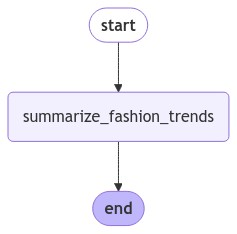

In [256]:
def draw_graph(graph: CompiledStateGraph):
    display(Image(graph.get_graph().draw_mermaid_png()))

draw_graph(graph)

In [257]:
init_msg = [HumanMessage(content="Search 5 websites about men's shoes.")]
for event in graph.stream({"messages": init_msg}):
    for value in event.values():
        print("Assistant:", value["messages"][-1].content)

AGENT DONE SUMMARIZING FINDINGS
Based on my research, here's a concise summary of the latest fashion trends in men's shoes:

**Dress Shoes:**

* The 20 Best Dress Shoes for Men in 2024 features a range of styles, including suede loafers, classic wingtips, and cap-toe designs from top brands like Ecco, Rockport, and Johnston & Murphy.
* Zappos' best-reviewed dress shoes include lace-up, Oxford, cap-toe, moccasin, and Chukka style shoes from the same brands.

**Fall Fashion Trends:**

* According to Men's Fall Fashion Trends 2024, five styles to know are:
	+ Relaxed-fit suits
	+ Corduroy pants
	+ Oversized blazers
	+ Patterned shirts with slim ties
	+ Minimalist sneakers

**Men's Shoes on Sale:**

* Nordstrom offers a great selection of Men's Shoes on Sale, featuring sneakers, slippers, boots, sandals, and more from top brands at discounted prices.

Overall, the trends suggest that men's fashion is leaning towards comfort, practicality, and versatility. Dress shoes are about classic desi

In [258]:
raw_docs = retriever.invoke("Men's winter styles")

for doc in raw_docs:
    print(doc.page_content)
    print(doc.metadata["url"])

BEST WINTER COATS FOR MEN 2024. All 33 of these coats are excellent choices to add to any stylish man's wardrobe. Let's take a closer look at each individual coat (updated for 2024). ... Style. Winter coats may not be known as the most stylish, but the most important factor is not placing fashion over function during this season. Also get ...
https://www.gentlemanwithin.com/best-winter-coats-for-men/
The 10 Best Winter Pants for Men, From Billy Reid to Brunello Cucinelli When the weather outside is frightful, keep your legs delightfully warm in these insulating styles. Modified on January 6 ...
https://robbreport.com/style/menswear/best-winter-pants-men-1234791817/
Keep reading for unique history, style inspiration, and the complete round-up of the different types of jackets for men. Key Takeaways Different types of jackets for men suit different seasons.
https://www.fashionbeans.com/article/types-of-jackets-for-men/
Explore the top 18 fall jackets for men in 2024, from casual bomber j

## How to Prompt the Agent for a Specific Goal
- "Give me the latest trends in fashion."
Agent should be able to keep searching websites and continually asking questions until it thinks it's answered all the user's questions.
- Help the agent along by introducing it to several key fashion product categories to iterate on in its search engine.
- Tell it that it needs 2-3 examples of each to be considered done searching.